In [1]:
import sys
import yaml
sys.path.insert(1, '../')

from ultraplace.core import covmod
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rc('legend',fontsize=14)

# PyCCL Example
## Load in some nzs

In [2]:
nz__0 = np.load("nzs/nz_DESwl__0.npz")
nz__1 = np.load("nzs/nz_DESwl__1.npz")
nz__2 = np.load("nzs/nz_DESwl__2.npz")
nz__3 = np.load("nzs/nz_DESwl__3.npz")

In [3]:
nzs = {"0": nz__0,
       "1": nz__1,
       "2": nz__2,
       "3": nz__3}

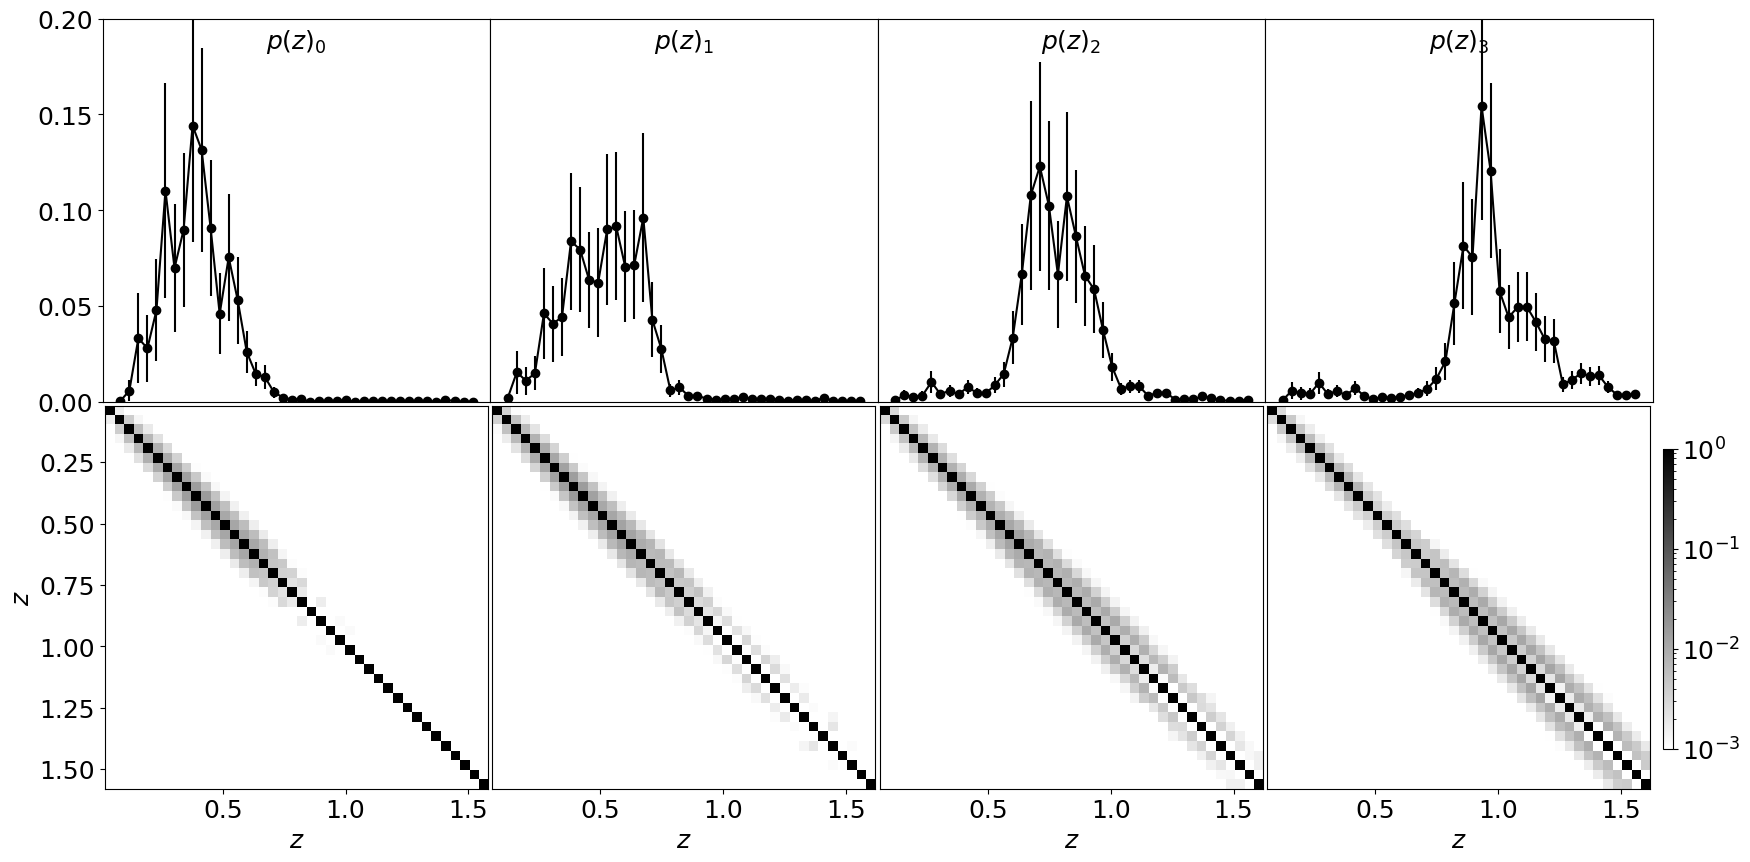

In [4]:
figure, axis = plt.subplots(2, 4, figsize=(20,10))
figure.subplots_adjust(wspace=0, hspace=0.01)
for i in range(0, 4):
    nzzs = nzs["{}".format(i)]
    z = nzzs["z"]
    dndz = nzzs["dndz"]
    cov = nzzs["cov"]
    err = np.sqrt(np.diag(cov))
    corr = cov / (np.outer(err, err))
    axis[0 , i].errorbar(z, dndz, yerr=err, fmt='ko-', label="$DESY1wl_{}$".format(i))
    axis[0, i].set_ylim(0, 0.2)
    axis[0, i].set_title(r"$p(z)_{}$".format(i), y=0.9)
    axis[0, i].set_xticks([])
    if i > 0:
        axis[0, i].set_yticks([])
    
    im = axis[1, i].imshow(abs(corr), cmap='gray_r', norm=LogNorm(vmin=0.001, vmax=1),
                           extent=[min(z), max(z), max(z), min(z)])
    if i > 0:
        axis[1, i].set_yticks([])
    else:
        axis[1, i].set_ylabel(r"$z$")
    axis[1, i].set_xlabel(r"$z$")
cbar_ax = figure.add_axes([0.905, 0.15, 0.005, 0.3])
figure.colorbar(im, cax=cbar_ax)

## Wrap CCL to get the theory

In [5]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.049, h=0.67, sigma8=0.81, n_s=0.96)
ells = np.arange(100, 2000, 100)

In [6]:
def theory_wlwl(cosmo, ells,
        nz_0=nz__0['dndz'],
        nz_1=nz__1['dndz'],
        nz_2=nz__2['dndz'],
        nz_3=nz__3['dndz']):
    tracer__0 = ccl.WeakLensingTracer(cosmo, has_shear=True, dndz=(nz__0['z'], nz_0))
    tracer__1 = ccl.WeakLensingTracer(cosmo, has_shear=True, dndz=(nz__1['z'], nz_1))
    tracer__2 = ccl.WeakLensingTracer(cosmo, has_shear=True, dndz=(nz__2['z'], nz_2))
    tracer__3 = ccl.WeakLensingTracer(cosmo, has_shear=True, dndz=(nz__3['z'], nz_3))

    clt__00 = ccl.angular_cl(cosmo, tracer__0, tracer__0, ells)
    clt__11 = ccl.angular_cl(cosmo, tracer__1, tracer__1, ells) 
    clt__22 = ccl.angular_cl(cosmo, tracer__2, tracer__2, ells) 
    clt__33 = ccl.angular_cl(cosmo, tracer__3, tracer__3, ells)

    return np.concatenate([
        clt__00,
        clt__11,
        clt__22,
        clt__33])

def theory_gcgc(cosmo, ells,
        nz_0=nz__0['dndz'],
        nz_1=nz__1['dndz'],
        nz_2=nz__2['dndz'],
        nz_3=nz__3['dndz']):
    tracer__0 = ccl.NumberCountsTracer(cosmo, has_rsd=False, bias=(nz__0['z'], np.ones_like(nz__0['z'])),
                                       dndz=(nz__0['z'], nz_0))
    tracer__1 = ccl.NumberCountsTracer(cosmo, has_rsd=False, bias=(nz__1['z'], np.ones_like(nz__1['z'])),
                                        dndz=(nz__1['z'], nz_1))
    tracer__2 = ccl.NumberCountsTracer(cosmo, has_rsd=False, bias=(nz__2['z'], np.ones_like(nz__2['z'])),
                                       dndz=(nz__2['z'], nz_2))
    tracer__3 = ccl.NumberCountsTracer(cosmo, has_rsd=False, bias=(nz__3['z'], np.ones_like(nz__3['z'])),
                                       dndz=(nz__3['z'], nz_3))

    clt__00 = ccl.angular_cl(cosmo, tracer__0, tracer__0, ells)
    clt__11 = ccl.angular_cl(cosmo, tracer__1, tracer__1, ells) 
    clt__22 = ccl.angular_cl(cosmo, tracer__2, tracer__2, ells) 
    clt__33 = ccl.angular_cl(cosmo, tracer__3, tracer__3, ells)

    return np.concatenate([
        clt__00,
        clt__11,
        clt__22,
        clt__33])

## Compute the Jacobian

In [7]:
def jacobian(cosmo, ells,
        theory=theory_wlwl,
        nz_0=nz__0['dndz'],
        nz_1=nz__1['dndz'],
        nz_2=nz__2['dndz'],
        nz_3=nz__3['dndz']):
    d = 0.005
    n_cls = 76
    m  = len(nz_0)
    T0 = np.zeros([m, n_cls])
    T1 = np.zeros([m, n_cls])
    T2 = np.zeros([m, n_cls])
    T3 = np.zeros([m, n_cls])
    for i in np.arange(0,m):
        e = np.zeros(m)
        e[i] = d
        T0[i] = (theory(cosmo, ells, nz_0=nz_0+e) - theory(cosmo, ells, nz_0=nz_0-e)) / (2*d)
        T1[i] = (theory(cosmo, ells, nz_1=nz_1+e) - theory(cosmo, ells, nz_1=nz_1-e)) / (2*d)
        T2[i] = (theory(cosmo, ells, nz_2=nz_2+e) - theory(cosmo, ells, nz_2=nz_2-e)) / (2*d)
        T3[i] = (theory(cosmo, ells, nz_3=nz_3+e) - theory(cosmo, ells, nz_3=nz_3-e)) / (2*d)
    return T0, T1, T2, T3

## Use Ultraplace to compute the covariance contribution
### WL-WL

In [8]:
T0, T1, T2, T3 = jacobian(cosmo, ells, theory=theory_wlwl)

/home/jaimerz/anaconda3/envs/tutorials/lib/python3.9/site-packages/pyccl/tracers.py:110: CCLWarning: The number of samples in the n(z) (40) is smaller than the number of samples in the lensing kernel (256). Consider disabling spline integration for the lensing kernel by setting pyccl.gsl_params.LENSING_KERNEL_SPLINE_INTEGRATION = False
  warnings.warn(


In [9]:
products = {'1': {'J': T0, 'P': nz__0['cov']},
            '2': {'J': T1, 'P': nz__1['cov']},
            '3': {'J': T2, 'P': nz__2['cov']},
            '4': {'J': T3, 'P': nz__3['cov']}}

In [10]:
data_cov = np.zeros((76, 76))

In [11]:
tpt = covmod(data_cov, products)

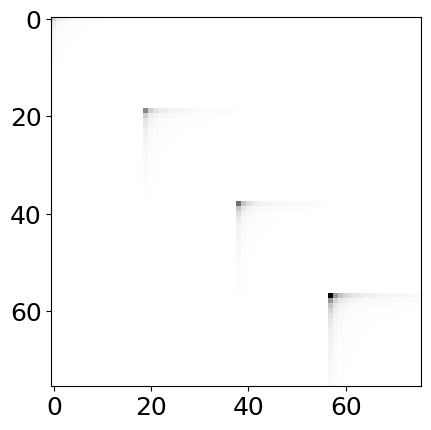

In [12]:
plt.imshow(tpt, cmap='gray_r')

### GC-GC

In [13]:
T0, T1, T2, T3 = jacobian(cosmo, ells, theory=theory_gcgc)

In [14]:
products = {'1': {'J': T0, 'P': nz__0['cov']},
            '2': {'J': T1, 'P': nz__1['cov']},
            '3': {'J': T2, 'P': nz__2['cov']},
            '4': {'J': T3, 'P': nz__3['cov']}}

In [15]:
data_cov = np.zeros((76, 76))

In [16]:
tpt = covmod(data_cov, products)

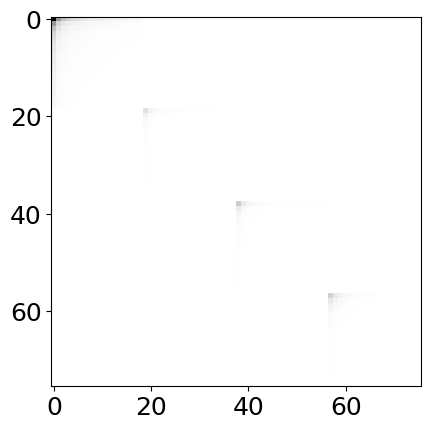

In [17]:
plt.imshow(tpt, cmap='gray_r')